In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qim3d
import dxchange
import olefile
import compoundfiles
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import sys

/home/s184058/.conda/envs/qim/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
astropy module not found


In [5]:
qim3d.io.logger.set_level_info()

In [6]:
txrm_file = 'data/glasfiber_test_4X-40kV-LE3-15s-5p6micro.txrm'



In [11]:
vol, _ = qim3d.io.load(txrm_file,virtual_stack=False)
vol_mm, offsets = qim3d.io.load(txrm_file,virtual_stack=True) # return offset temporarily to explore issue

Offsets are not ascending, some slices are erroneous
Loaded shape: (1601, 1014, 1014)
Using 3.1 GB of memory
Offsets are not ascending, some slices are erroneous
Loaded shape: (1601, 1014, 1014)
Using 80.0 B of memory


In [12]:
# offsets is a dictionary where all keys are the slice names and values are the corresponding offsets in bytes where the slice begins in the TXRM file (see _get_ole_offsets(ole) function in qim3d.io.load() for details)
offsets

{'ImageData1/Image1': 4468736,
 'ImageData1/Image2': 6533120,
 'ImageData1/Image3': 8593408,
 'ImageData1/Image4': 10657792,
 'ImageData1/Image5': 12718080,
 'ImageData1/Image6': 14782464,
 'ImageData1/Image7': 16842752,
 'ImageData1/Image8': 18903040,
 'ImageData1/Image9': 20967424,
 'ImageData1/Image10': 23027712,
 'ImageData1/Image11': 25092096,
 'ImageData1/Image12': 27152384,
 'ImageData1/Image13': 29216768,
 'ImageData1/Image14': 31277056,
 'ImageData1/Image15': 33341440,
 'ImageData1/Image16': 35401728,
 'ImageData1/Image17': 37470208,
 'ImageData1/Image18': 39530496,
 'ImageData1/Image19': 41594880,
 'ImageData1/Image20': 43655168,
 'ImageData1/Image21': 45719552,
 'ImageData1/Image22': 47779840,
 'ImageData1/Image23': 49844224,
 'ImageData1/Image24': 51904512,
 'ImageData1/Image25': 53968896,
 'ImageData1/Image26': 56033280,
 'ImageData1/Image27': 58097664,
 'ImageData1/Image28': 60157952,
 'ImageData1/Image29': 62222336,
 'ImageData1/Image30': 64282624,
 'ImageData1/Image31':

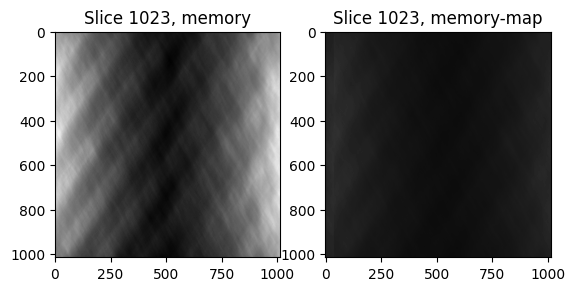

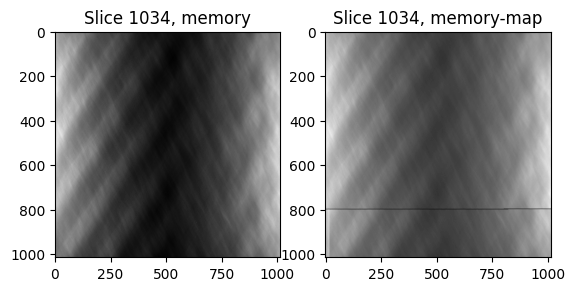

In [22]:
for idx in range(vol.shape[0]):
    if np.any(vol[idx]!=vol_mm[idx]):
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(vol[idx],cmap='gray')
        ax[1].imshow(vol_mm[idx],cmap='gray')
        ax[0].set_title(f'Slice {idx}, memory')
        ax[1].set_title(f'Slice {idx}, memory-map')

        plt.show()  

So two out of 1601 slices are erroneous in this dataset. Let's inspect this further

# Case 1: slice 1023

In [38]:
# Check offset values of the coresponding slices (check offset of slices before and after as well)
print('Slice 1021:',offsets[list(offsets.keys())[1021]])
print('Slice 1022:',offsets[list(offsets.keys())[1022]])
print('Slice 1023:',offsets[list(offsets.keys())[1023]])
print('Slice 1024:',offsets[list(offsets.keys())[1024]])
print('Slice 1025:',offsets[list(offsets.keys())[1025]])

Slice 1021: 2118750208
Slice 1022: 2120814592
Slice 1023: 2091933696
Slice 1024: 2125238272
Slice 1025: 2127298560


In [49]:
# So offset for slice 1023 seems to start somewhere entirely different than the adjacent slices
# I have found out that all data is placed in so-called sectors that each contains 4096 bytes of data
# Using compoundfiles (newer version of olefile) we can get the indices of each sector of a slice:
comp = compoundfiles.CompoundFileReader(txrm_file)
slice1023 = comp.open(list(offsets.keys())[1023])
print(f'{slice1023._sector_size=}')
print(f'{slice1023._sectors=}')

slice1023._sector_size=4096
slice1023._sectors=array('L', [510725, 518314, 518315, 518316, 518317, 518318, 518319, 518320, 518321, 518322, 518323, 518324, 518325, 518326, 518327, 518328, 518329, 518330, 518331, 518332, 518333, 518334, 518335, 518336, 518337, 518338, 518339, 518340, 518341, 518342, 518343, 518344, 518345, 518346, 518347, 518348, 518349, 518350, 518351, 518352, 518353, 518354, 518355, 518356, 518357, 518358, 518359, 518360, 518361, 518362, 518363, 518364, 518365, 518366, 518367, 518368, 518369, 518370, 518371, 518372, 518373, 518374, 518375, 518376, 518377, 518378, 518379, 518380, 518381, 518382, 518383, 518384, 518385, 518386, 518387, 518388, 518389, 518390, 518391, 518392, 518393, 518394, 518395, 518396, 518397, 518398, 518399, 518400, 518401, 518402, 518403, 518404, 518405, 518406, 518407, 518408, 518409, 518410, 518411, 518412, 518413, 518414, 518415, 518416, 518417, 518418, 518419, 518420, 518421, 518422, 518423, 518424, 518425, 518426, 518427, 518428, 518429, 51843

In [55]:
# See what the slice index corresponds to:
print(list(offsets.keys())[1023])

ImageData11/Image1024


In [53]:
# Ok, so while all sectors starting from i=1 are incrementing by one index, the first sectors is located a completely different place.
# The problem is that the method used to find the offsets is only returning the offset of the first sector:
import olefile
ole = olefile.OleFileIO(txrm_file)
for stream in ole.listdir():
        if stream[0].startswith('ImageData'):
            sid = ole._find(stream)
            direntry = ole.direntries[sid]
            size = direntry.size
            sect_start = direntry.isectStart
            if size >= ole.minisectorcutoff:
                offset = ole.sectorsize * (sect_start+1)
                print(f"{stream=}, {sid=}, {size=}, {sect_start=}, {offset=}")
                # print "%s: sid=%d, size=%d, sect_start=%d, offset=%X" % (
                #     repr('/'.join(stream)), sid, size, sect_start, offset)

stream=['ImageData1', 'Image1'], sid=1575, size=2056392, sect_start=1090, offset=4468736
stream=['ImageData1', 'Image10'], sid=1584, size=2056392, sect_start=5621, offset=23027712
stream=['ImageData1', 'Image100'], sid=1674, size=2056392, sect_start=50946, offset=208678912
stream=['ImageData1', 'Image11'], sid=1585, size=2056392, sect_start=6125, offset=25092096
stream=['ImageData1', 'Image12'], sid=1586, size=2056392, sect_start=6628, offset=27152384
stream=['ImageData1', 'Image13'], sid=1587, size=2056392, sect_start=7132, offset=29216768
stream=['ImageData1', 'Image14'], sid=1588, size=2056392, sect_start=7635, offset=31277056
stream=['ImageData1', 'Image15'], sid=1589, size=2056392, sect_start=8139, offset=33341440
stream=['ImageData1', 'Image16'], sid=1590, size=2056392, sect_start=8642, offset=35401728
stream=['ImageData1', 'Image17'], sid=1591, size=2056392, sect_start=9147, offset=37470208
stream=['ImageData1', 'Image18'], sid=1592, size=2056392, sect_start=9650, offset=3953049

In [ ]:
# Scroll up to ImageData10/Image1023 or have a look below at the relevant print output:

# stream=['ImageData11', 'Image1022'], sid=2608, size=2056392, sect_start=517272, offset=2118750208
# stream=['ImageData11', 'Image1023'], sid=2609, size=2056392, sect_start=517776, offset=2120814592
# stream=['ImageData11', 'Image1024'], sid=2610, size=2056392, sect_start=510725, offset=2091933696
# stream=['ImageData11', 'Image1025'], sid=2611, size=2056392, sect_start=518856, offset=2125238272
# stream=['ImageData11', 'Image1026'], sid=2612, size=2056392, sect_start=519359, offset=2127298560

In [ ]:
# The reason I am stucked with this is that np.memmap only takes one offset and then a shape and datatype so it knows how many bytes it should include starting from the offset
# But for this slice not all bytes are consecutive which causes

# Case 2: slice 1034

In [56]:
# Check offset values of the coresponding slices (check offset of slices before and after as well)
print('Slice 1021:',offsets[list(offsets.keys())[1032]])
print('Slice 1022:',offsets[list(offsets.keys())[1033]])
print('Slice 1023:',offsets[list(offsets.keys())[1034]])
print('Slice 1024:',offsets[list(offsets.keys())[1035]])
print('Slice 1025:',offsets[list(offsets.keys())[1036]])

Slice 1021: 2141736960
Slice 1022: 2143797248
Slice 1023: 2145861632
Slice 1024: 2147926016
Slice 1025: 2149990400


In [ ]:
# Ok, so the offset does not look particular off in this case

In [70]:
comp = compoundfiles.CompoundFileReader(txrm_file)
slice1034 = comp.open(list(offsets.keys())[1034])
print(f'{slice1034._sector_size=}')
print(f'{slice1034._sectors=}')

slice1034._sector_size=4096
slice1034._sectors=array('L', [523891, 523892, 523893, 523894, 523895, 523896, 523897, 523898, 523899, 523900, 523901, 523902, 523903, 523904, 523905, 523906, 523907, 523908, 523909, 523910, 523911, 523912, 523913, 523914, 523915, 523916, 523917, 523918, 523919, 523920, 523921, 523922, 523923, 523924, 523925, 523926, 523927, 523928, 523929, 523930, 523931, 523932, 523933, 523934, 523935, 523936, 523937, 523938, 523939, 523940, 523941, 523942, 523943, 523944, 523945, 523946, 523947, 523948, 523949, 523950, 523951, 523952, 523953, 523954, 523955, 523956, 523957, 523958, 523959, 523960, 523961, 523962, 523963, 523964, 523965, 523966, 523967, 523968, 523969, 523970, 523971, 523972, 523973, 523974, 523975, 523976, 523977, 523978, 523979, 523980, 523981, 523982, 523983, 523984, 523985, 523986, 523987, 523988, 523989, 523990, 523991, 523992, 523993, 523994, 523995, 523996, 523997, 523998, 523999, 524000, 524001, 524002, 524003, 524004, 524005, 524006, 524007, 52400

In [75]:
# Nothing obviously wrong to spot here, lets see if all sectors are coherent
np.diff(slice1034._sectors)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

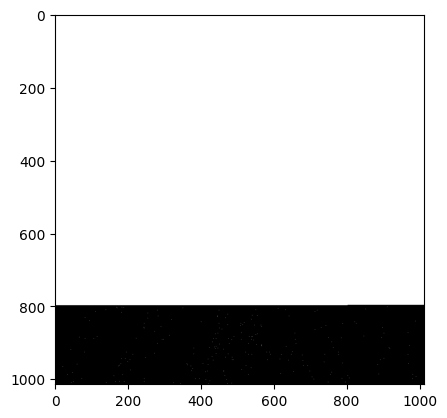

In [86]:
# AHA! So around 80% into the slice one sector index is skipped. WTF, makes no sense.
# This results in the following, where everything is correct until that particular sector is skipped by one index
plt.imshow(vol[1034]==vol_mm[1034],cmap='gray')